# Evaluation of the benchmarking approach used in "Dissecting cell identity via network inference and in silico gene perturbation"

Here we evaluate the performance of benchmarking approach taken by the original paper of "Dissecting cell identity via network inference and in silico gene perturbation". For the description of the problem, refer to the pdf file posted in the main directory. 
In this notebook, we present the following evaluations: 

- Evaluation of the original implementation of the benchmarking method
- Evaluation of the new implementation of the benchmarking method
- Evaluation of the benchmarking data in terms of TFs count per tissue
- Evaluation of the additive value of the regression based GRN inference over the base GRN

Install the package from the main directory `pip install .`

In [13]:
import os

data_dir = f'../external'
os.makedirs(data_dir, exist_ok=True)

## Benchmarking data
The authors have provide the data required to reproduce the benchmarkiung results presented in the paper. To run the code, we first download the data from this link, unzip it, and place it in data_dir directory. 

https://drive.google.com/file/d/17C9-PNcroDtFycnMBxoNNjbEk1Fcwo_X/view?usp=drive_link

## Evaluation of the original implementation of the benchmarking method

### Calculate benchmarking scores using CO original implementation implementation

In [17]:
%run ../CO_evaluation/post_GRN/calculate_scores_CO.py --benchmark-method CO --verbose --data_dir {data_dir}

../external


Different samples: 100%|██████████| 13/13 [1:16:16<00:00, 352.03s/it]


output -> /Users/nourisa/projects/ongoing/CO_evaluation/results/CO/benchmark/scores_CO/grn_score_summary_22.parquet


Run for metrics: 100%|██████████| 2/2 [00:00<00:00, 258.23it/s]

output -> /Users/nourisa/projects/ongoing/CO_evaluation/results/CO/benchmark/scores_CO/scores_all_auc.csv
output -> /Users/nourisa/projects/ongoing/CO_evaluation/results/CO/benchmark/scores_CO/scores_all_epr.csv


output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_CO/figures/auc.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_CO/figures/epr.png


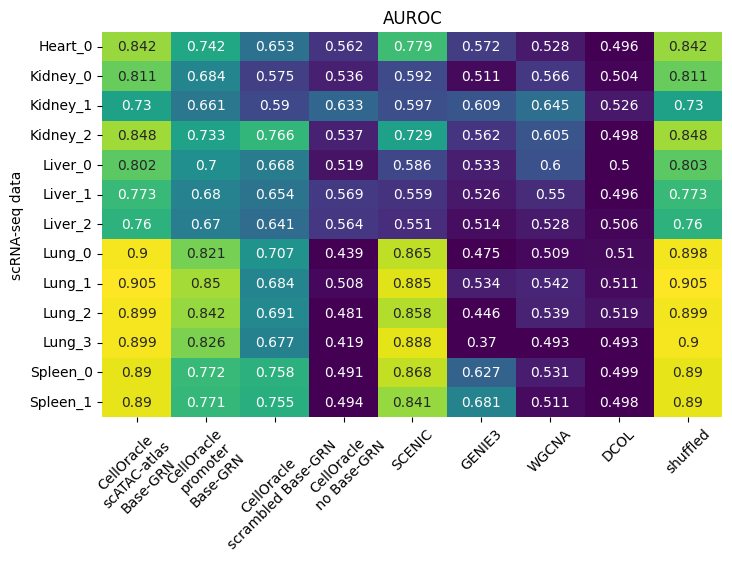

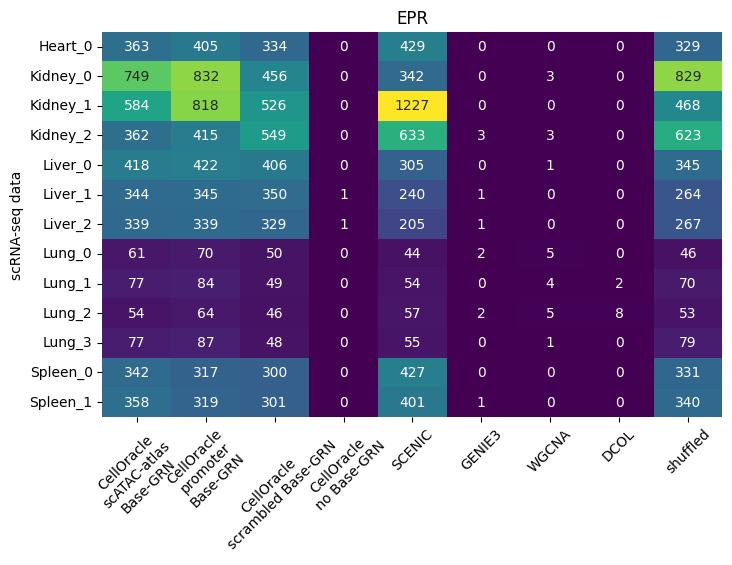

In [2]:
%run ../CO_evaluation/post_GRN/plot_scores.py --verbose --benchmark-method CO

### Calculate the stats of class misbalance in the case of the original imeplentation

output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/stats/plot_CO.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/stats/plot_CO_GT_TFs.png


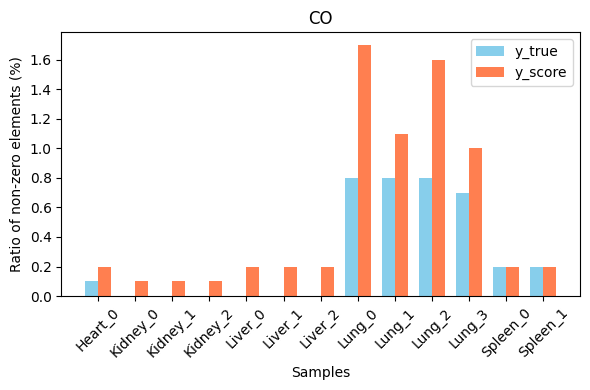

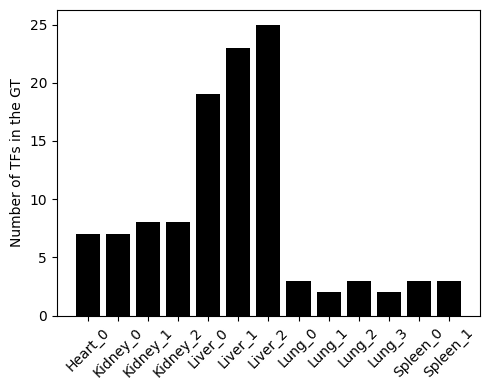

In [4]:
# calculate and show the significane of class misbalance in the original implementation of CO 
%run ../CO_evaluation/post_GRN/plot_benchmarking_stats.py --benchmark-method CO --verbose

## Evaluation of the new implementation of the benchmarking method

### Calculate benchmarking scores using the alternative implementation


Different samples: 100%|██████████| 13/13 [00:02<00:00,  6.01it/s]


output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/grn_score_summary_22.parquet


Run for metrics: 100%|██████████| 6/6 [00:00<00:00, 104.54it/s]


output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/scores_all_auc.csv
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/scores_all_auc_random.csv
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/scores_all_epr.csv
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/scores_all_auc_pr.csv
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/scores_all_f1.csv
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/scores_all_f1_random.csv
auc_random
f1_random
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/auc.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/fi

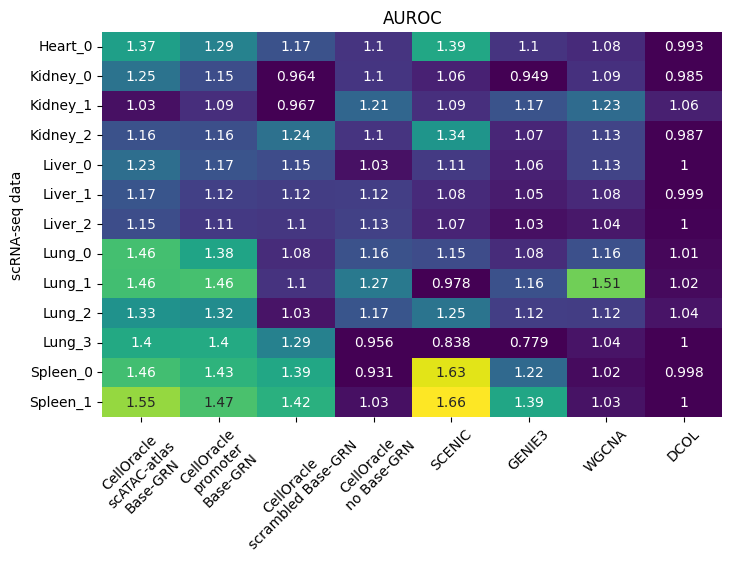

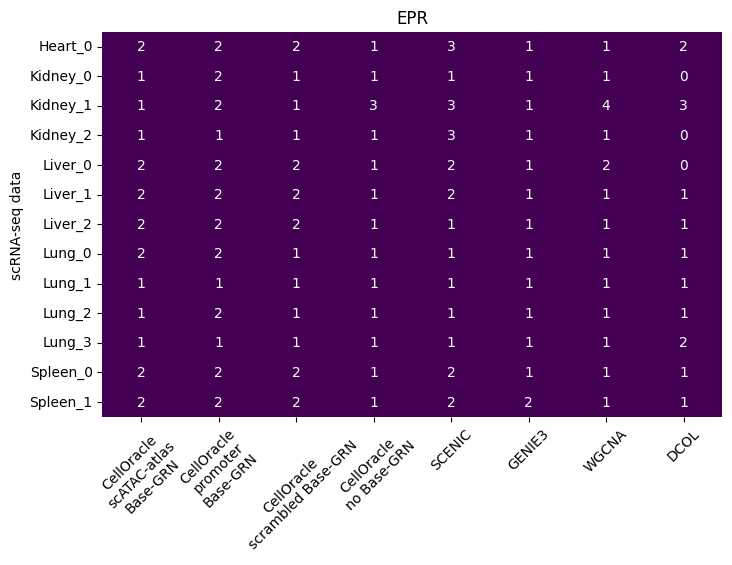

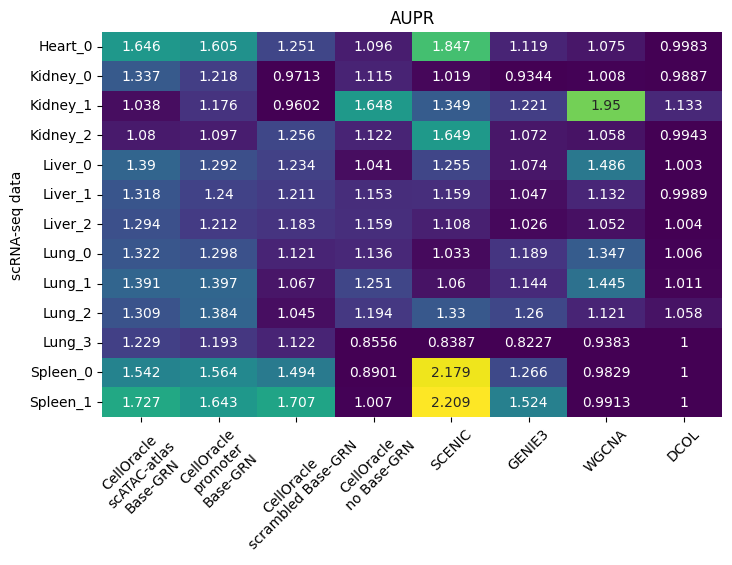

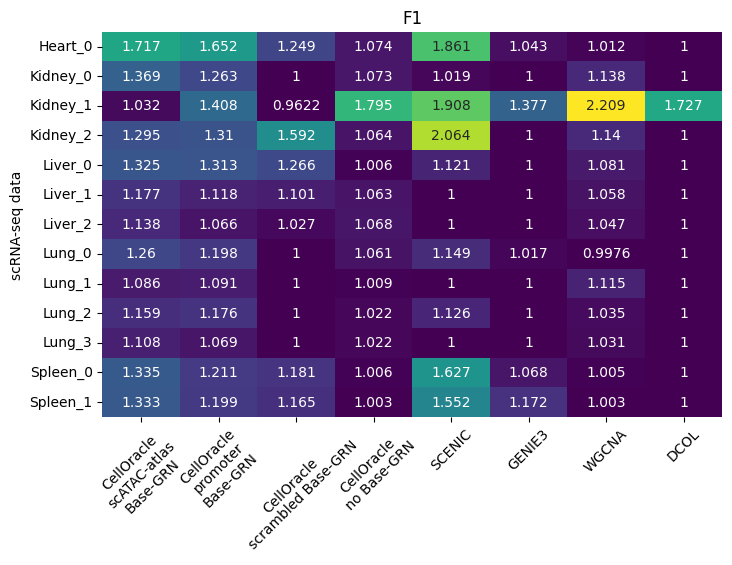

In [50]:
# calculate benchmarking scores using the alternative formulation
%run ../CO_evaluation/post_GRN/calculate_scores_CO.py --benchmark-method M1 --verbose 
# plot the scores 
%run ../CO_evaluation/post_GRN/plot_scores.py --verbose --benchmark-method M1

### Calculate the stats of class misbalance in the case of the alternative imeplentation

output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/stats/plot_M1.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/stats/plot_M1_GT_TFs.png


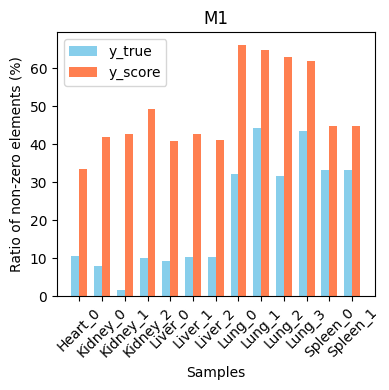

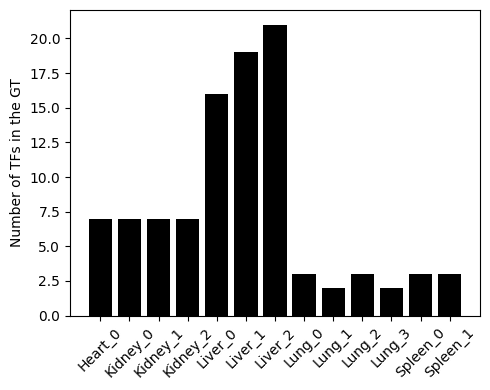

In [23]:
# Show the class misbalance stats for the alternative implementation
%run ../CO_evaluation/post_GRN/plot_benchmarking_stats.py --benchmark-method M1 --verbose

## Evaluation of the additive value of the regression based GRN inference over the base GRN

auc_random
auc_pr_random
f1_random
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/auc.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/epr.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/auc_pr.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/f1.png


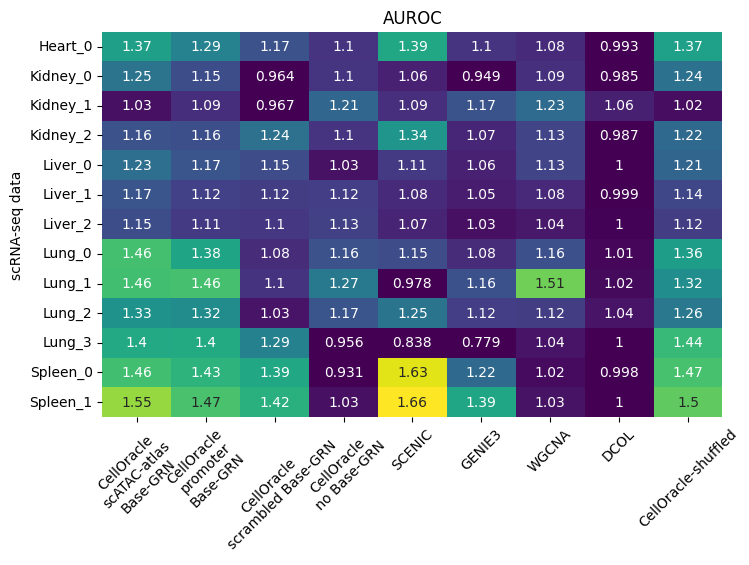

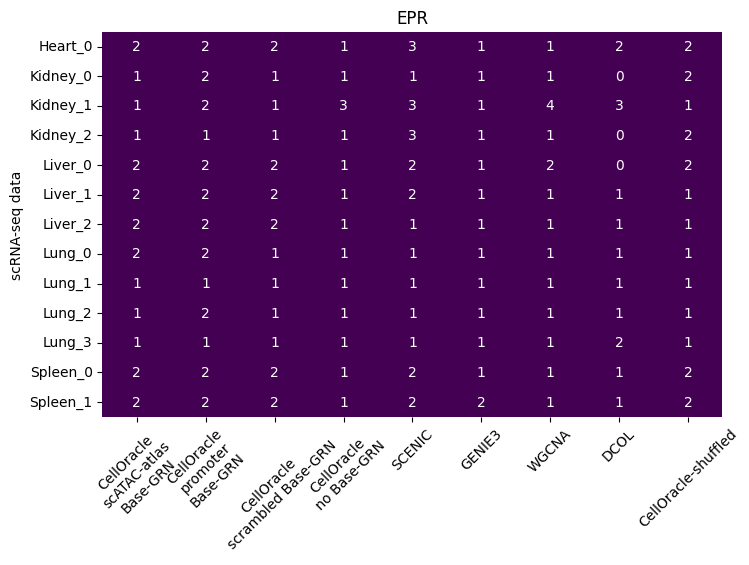

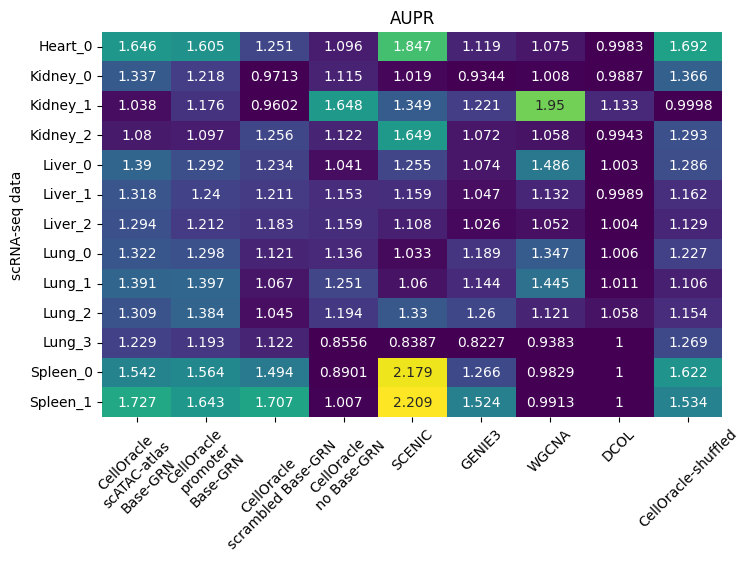

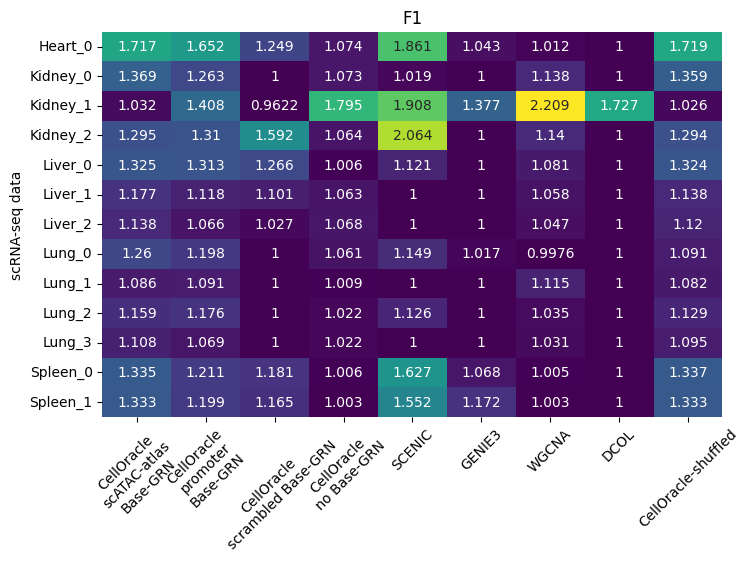

In [107]:
# calculate benchmarking scores for shuffled GRN values
%run ../CO_evaluation/post_GRN/calculate_scores_CO.py --benchmark-method M1 --shuffle --verbose 
# plot the scores 
%run ../CO_evaluation/post_GRN/plot_scores.py --verbose --benchmark-method M1

### Mean score across different samples for shuffled and inferred values

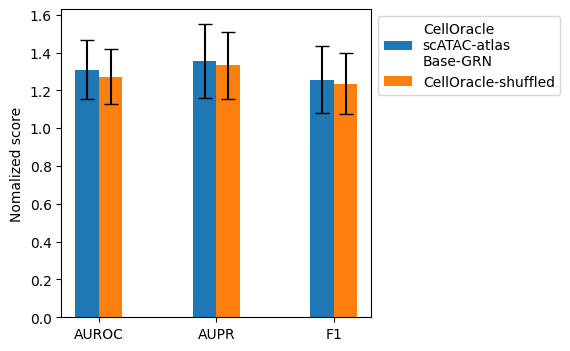

In [140]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Given lists to store data
methods = ['CellOracle\nscATAC-atlas\nBase-GRN', 'shuffled']
metrics = ['auc', 'auc_pr', 'f1']
means = []
stds = []

# Assuming 'M1' is the only benchmark method we are evaluating
benchmark_method = 'M1'
SCORES_DIR = f'../results/CO/benchmark/scores_{benchmark_method}'

# Collecting the mean and standard deviation for each method and metric
for metric in metrics:
    df = pd.read_csv(f'{SCORES_DIR}/scores_all_{metric}.csv', index_col=0)
    if metric in ['auc_pr', 'f1', 'auc']:  # Normalize if needed
        baseline = pd.read_csv(f'{SCORES_DIR}/scores_all_{metric}_random.csv', index_col=0)
        df = df / baseline
    means.append(df.mean().values)
    stds.append(df.std().values)

# Convert lists to numpy arrays
means = np.array(means)
stds = np.array(stds)

# Plotting
positions = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(4,4))

for i, method in enumerate(methods):
    if method=='shuffled':
        method = 'CellOracle-shuffled'
    ax.bar(positions - width/2 + i * width, means[:, i], width, yerr=stds[:, i], 
           label=method, capsize=5)
ax.set_ylabel('Nomalized score')
# ax.set_title('Scores by metric and method')
ax.set_xticks(positions)
ax.set_xticklabels([ 'AUROC',  'AUPR', 'F1'])
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


## Evaluation of the benchmarking data in terms of TFs count per tissue

In [56]:
import pandas as pd
import numpy as np
from CO_evaluation.imports import tissues
tfs_alltissues = []
for tissue in tissues:
    df= pd.read_csv(f"{data_dir}/celloracle_grn_benchmark/data/ground_truth_data/chip_atlas/data/{tissue}/chip_GT_links.csv", index_col=0)
    tfs_alltissues.append(df.tf.unique())

In [62]:
flattened_list = [item for sublist in tfs_alltissues for item in sublist]
np.shape(flattened_list)

(60,)